# 0.0.0 - Instruções e Breves Respostas

### Uma solução de machine learning utilizando ferramentas de big data
 
 Este projeto tem como objetivo a prática dos principais conceitos vistos em sala de aula em uma aplicação de data science
* Escolha uma base de dados (externa ou disponível no databricks-datasets)
    * Escolhemos a base de dados wine quality disponível no databricks-datasets
* Descreva a base de dados e onde está inserida no seu cluster
    * Criamos um novo diretório chamado 'letscode' e copiamos os dados do databricks-datasets para esse diretório (__seção 1.0.0__).
* Foi necessário uso do DBFS? Porque e com quais objetivos?
    * Utilizamos o DBFS para guardar nossos dados, criar novos diretórios e mover arquivos entre eles.
* Leitura da base de dados no Spark. Você utilizou o spark SQL, RDD ou dataframe?
    * Utilizamos o spark dataframe (__seção 2.1.0__)
* Realize os préprocessamentos necessários na base para utilização de um algoritmo de machine learning. Cite os pre processamentos realizados e porque foram escolhidos dessa forma (OBS. Maior quantidade de pré-processamentos possíveis diretamente no spark ao invés do pandas)
    * Eliminação da primeira linha por possuir apenas valores nulos (__seção 2.2.0__)
    * Transformação da coluna 'quality' em dummy (threshold > 6) (__seção 2.2.0__)
    * Eliminação de outras linhas por conter valores nulos (__seção 2.2.0__)
    * Filtragem por tipo de vinho (apenas vinho branco) (__seção 2.2.0__)
    * Drop das colunas contendo o tipo do vinho e da qualidade (__seção 2.2.0__) 
* Realize análise exploratória simples utilizando o matplotlib ou o seaborn (__seção 2.2.0__)
    * (__seção 2.4.0__)
* Escolha um algorimto de machine learning e realize o treinamento e teste do modelo, ilustrando o desempenho e diagnóstico do modelo
    * (__seção 2.5.0__)

# 1.0.0 - Hive

In [0]:
%sql

show databases

databaseName
default


In [0]:
%sql

create database projeto_final

In [0]:
%sql
use projeto_final

Verificamos quais arquivos temos disponíveis no databricks-datasets

In [0]:
dbutils.fs.ls('/databricks-datasets')

Out[1]: [FileInfo(path='dbfs:/databricks-datasets/', name='databricks-datasets/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/COVID/', name='COVID/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/README.md', name='README.md', size=976, modificationTime=1532468253000),
 FileInfo(path='dbfs:/databricks-datasets/Rdatasets/', name='Rdatasets/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/SPARK_README.md', name='SPARK_README.md', size=3359, modificationTime=1455043490000),
 FileInfo(path='dbfs:/databricks-datasets/adult/', name='adult/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/airlines/', name='airlines/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/amazon/', name='amazon/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/asa/', name='asa/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/atlas_higgs/', name='a

Criamos um diretório para podermos guardar nossos dados

In [0]:
dbutils.fs.mkdirs('/letscode')

Out[2]: True

Iremos trabalhar com o dataset __wine quality__. Por isso, copiamos os dados desse dataset, presentes no 'databrics-datasets', para nossa pasta 'projeto_final'. Uma vantagem desse dataset é que temos dados para vinhos brancos e vermelhos. Isso irá permitir que utilizemos partições.

In [0]:
dbutils.fs.cp('/databricks-datasets/wine-quality/', '/letscode', recurse = True)

Out[3]: True

Vemos apenas alguns dados iniciais apenas para termos uma noção da estrutura dos dados. Como podemos perceber, as colunas estão separadas por ';' e as linhas por '\n'. Iremos incorporar esses fatos na criação da tabela.

In [0]:
dbutils.fs.head('/letscode/winequality-red.csv', 300)

[Truncated to first 300 bytes]
Out[4]: '"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"\n7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5\n7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5\n7.8;0.76;0.04;2.3;0.092;15;54;0.'

Criamos nossa tabela. No momento ela está vazia, mas iremos preenchê-la na sequência. 

Como podemos perceber, estamos já preparando nossa tabela para receber dados particionados.

In [0]:
%sql
create table wine_quality(
  fixed_acidity float,
  volatile_acidity float,
  citric_acid float,
  residual_sugar float,
  chlorides float,
  free_sulfur_dioxide float, 
  total_sulfur_dioxide float,
  density float,
  pH float,
  sulphates float,
  alcohol float,
  quality int
)
row format delimited
fields terminated by ';'
lines terminated by '\n'
stored as textfile
partitioned by (type string)
location '/letscode/wine_quality'
tblproperties('skip.header.line.count'='1')


In [0]:
%sql
load data inpath '/letscode/winequality-red.csv' overwrite into table wine_quality partition(type='red_wine')

In [0]:
%sql
load data inpath '/letscode/winequality-white.csv' overwrite into table wine_quality partition(type='white_wine')

In [0]:
%sql
select * from wine_quality limit 10

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type
null,null,null,null,null,null,null,null,null,null,null,null,red_wine
7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red_wine
7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5,red_wine
7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5,red_wine
11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6,red_wine
7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red_wine
7.4,0.66,0.0,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,red_wine
7.9,0.6,0.06,1.6,0.069,15.0,59.0,0.9964,3.3,0.46,9.4,5,red_wine
7.3,0.65,0.0,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,red_wine
7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,red_wine


# 2.0.0 - PySpark

## 2.1.0 - Importação da tabela para o PySpark

Nativamente o Spark não em acesso aos nossos dados no Hive. Para isso, importamos a biblioteca do Python 'pyspark.sql' e instanciamos a classe 'HiveContext'.

In [0]:
from pyspark.sql import HiveContext
context = HiveContext(sc)

/databricks/spark/python/pyspark/sql/context.py:622: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  warnings.warn(


Agora, definimos de qual diretório ('projeto_final') desejamos importar qual tabela ('wine_quality').

In [0]:
dados = context.table('projeto_final.wine_quality')
dados.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|    type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+--------+
|         null|            null|       null|          null|     null|               null|                null|   null|null|     null|   null|   null|red_wine|
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|red_wine|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|red_wine|
|          7.8|            0.76|       0.04|  

In [0]:
dados.registerTempTable('wine_quality')

/databricks/spark/python/pyspark/sql/dataframe.py:146: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


## 2.2.0 - Pré Processamentos

Como podemos ver, a primeira linha possui apenas valores nulos. Por isso, a eliminamos.

In [0]:
dados = spark.createDataFrame(dados.tail(dados.count()-1), dados.schema)

Para nossa modelagem, estaremos realizando uma tarefa de classificação. Assim, temos que transformar a nossa variável dependente ('quality') em uma variável binária.

In [0]:
from pyspark.sql.functions import *

dados = dados.withColumn('quality_dummy',when(dados.quality > 6, 1).otherwise(0))
dados.select('quality_dummy').show()

+-------------+
|quality_dummy|
+-------------+
|            0|
|            0|
|            0|
|            0|
|            0|
|            0|
|            0|
|            1|
|            1|
|            0|
|            0|
|            0|
|            0|
|            0|
|            0|
|            0|
|            1|
|            0|
|            0|
|            0|
+-------------+
only showing top 20 rows



Ademais, verificamos se temos valores nulos. Como podemos ver, temos sim. Por esse motivo e pelo fato do número de nulos ser extremamente pequeno em relação ao tamanho da nossa base de dados, dropamos as linhas com valores nulos.

In [0]:
dados.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dados.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|quality|type|quality_dummy|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+-------------+
|            1|               1|          1|             1|        1|                  1|                   1|      1|  1|        1|      1|      1|   0|            0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+-------------+



In [0]:
dados = dados.na.drop()

In [0]:
dados.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dados.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|quality|type|quality_dummy|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+-------------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|   0|            0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+-------------+



Além disso, sabemos que vinhos brancos e vermelhos são bastante diferentes. Por esse motivo, não é ideal incorporar as duas classes em um único modelo. Assim, mantemos apenas os vinhos brancos, dado que temos mais dados para esse grupo (como podemos ver abaixo).

In [0]:
dados.groupBy('type').count().show()

+----------+-----+
|      type|count|
+----------+-----+
|  red_wine| 1599|
|white_wine| 4898|
+----------+-----+



In [0]:
dados = dados.filter(dados.type == "white_wine")

In [0]:
dados.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|      type|quality_dummy|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----------+-------------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|white_wine|            0|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|white_wine|            0|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|  

Por fim, na parte de preprocessamento, dropamos as colunas 'type' e 'quality'. Dropamos a primeira porque, depois de realizarmos a filtragem com base nela, ela possui um único valor e já não nos é mais útil; a segunda, dado que ela é uma transformação da nossa variável dependente ('wine_dummy') e estaria presente apenas se fossemos realizar uma regressão.

In [0]:
dados = dados.drop('type', 'quality')

In [0]:
dados.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality_dummy|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|            0|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|            0|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|            0|
|          7.2|            0.23|       0.32|           8.5|    0

## 2.3.0 - PySpark com Pandas

Agora, transformamos nossa PySpark dataframe para um dataframe do tipo pandas (como podemos ver abaixo).

In [0]:
dados_pandas = dados.toPandas()
type(dados_pandas)

Out[18]: pandas.core.frame.DataFrame

## 2.4.0 - Matplotlib e Seaborn

Nesse ponto, apressentamos alguns gráficos baseados nos dados. Alguns dos gráficos são diretamente copiados de um [artigo do medium](https://medium.com/data-science-prashantasinha/wine-quality-eda-642a9314c33a). Fazemos isso com o intuito de mostrar que não existe diferença nenhuma entre esse passo no PySpark e nas IDEs mais comuns (Jupyter, PyCharm, etc.).

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

### 2.4.1 - Simples Gráfico de Contagem da Variável Dependente

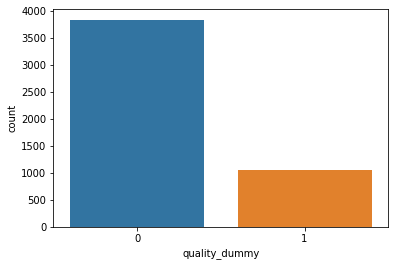

In [0]:
ax = sns.countplot(x='quality_dummy', data = dados_pandas)

### 2.4.2 - Análise Relacional (Pair Grid)

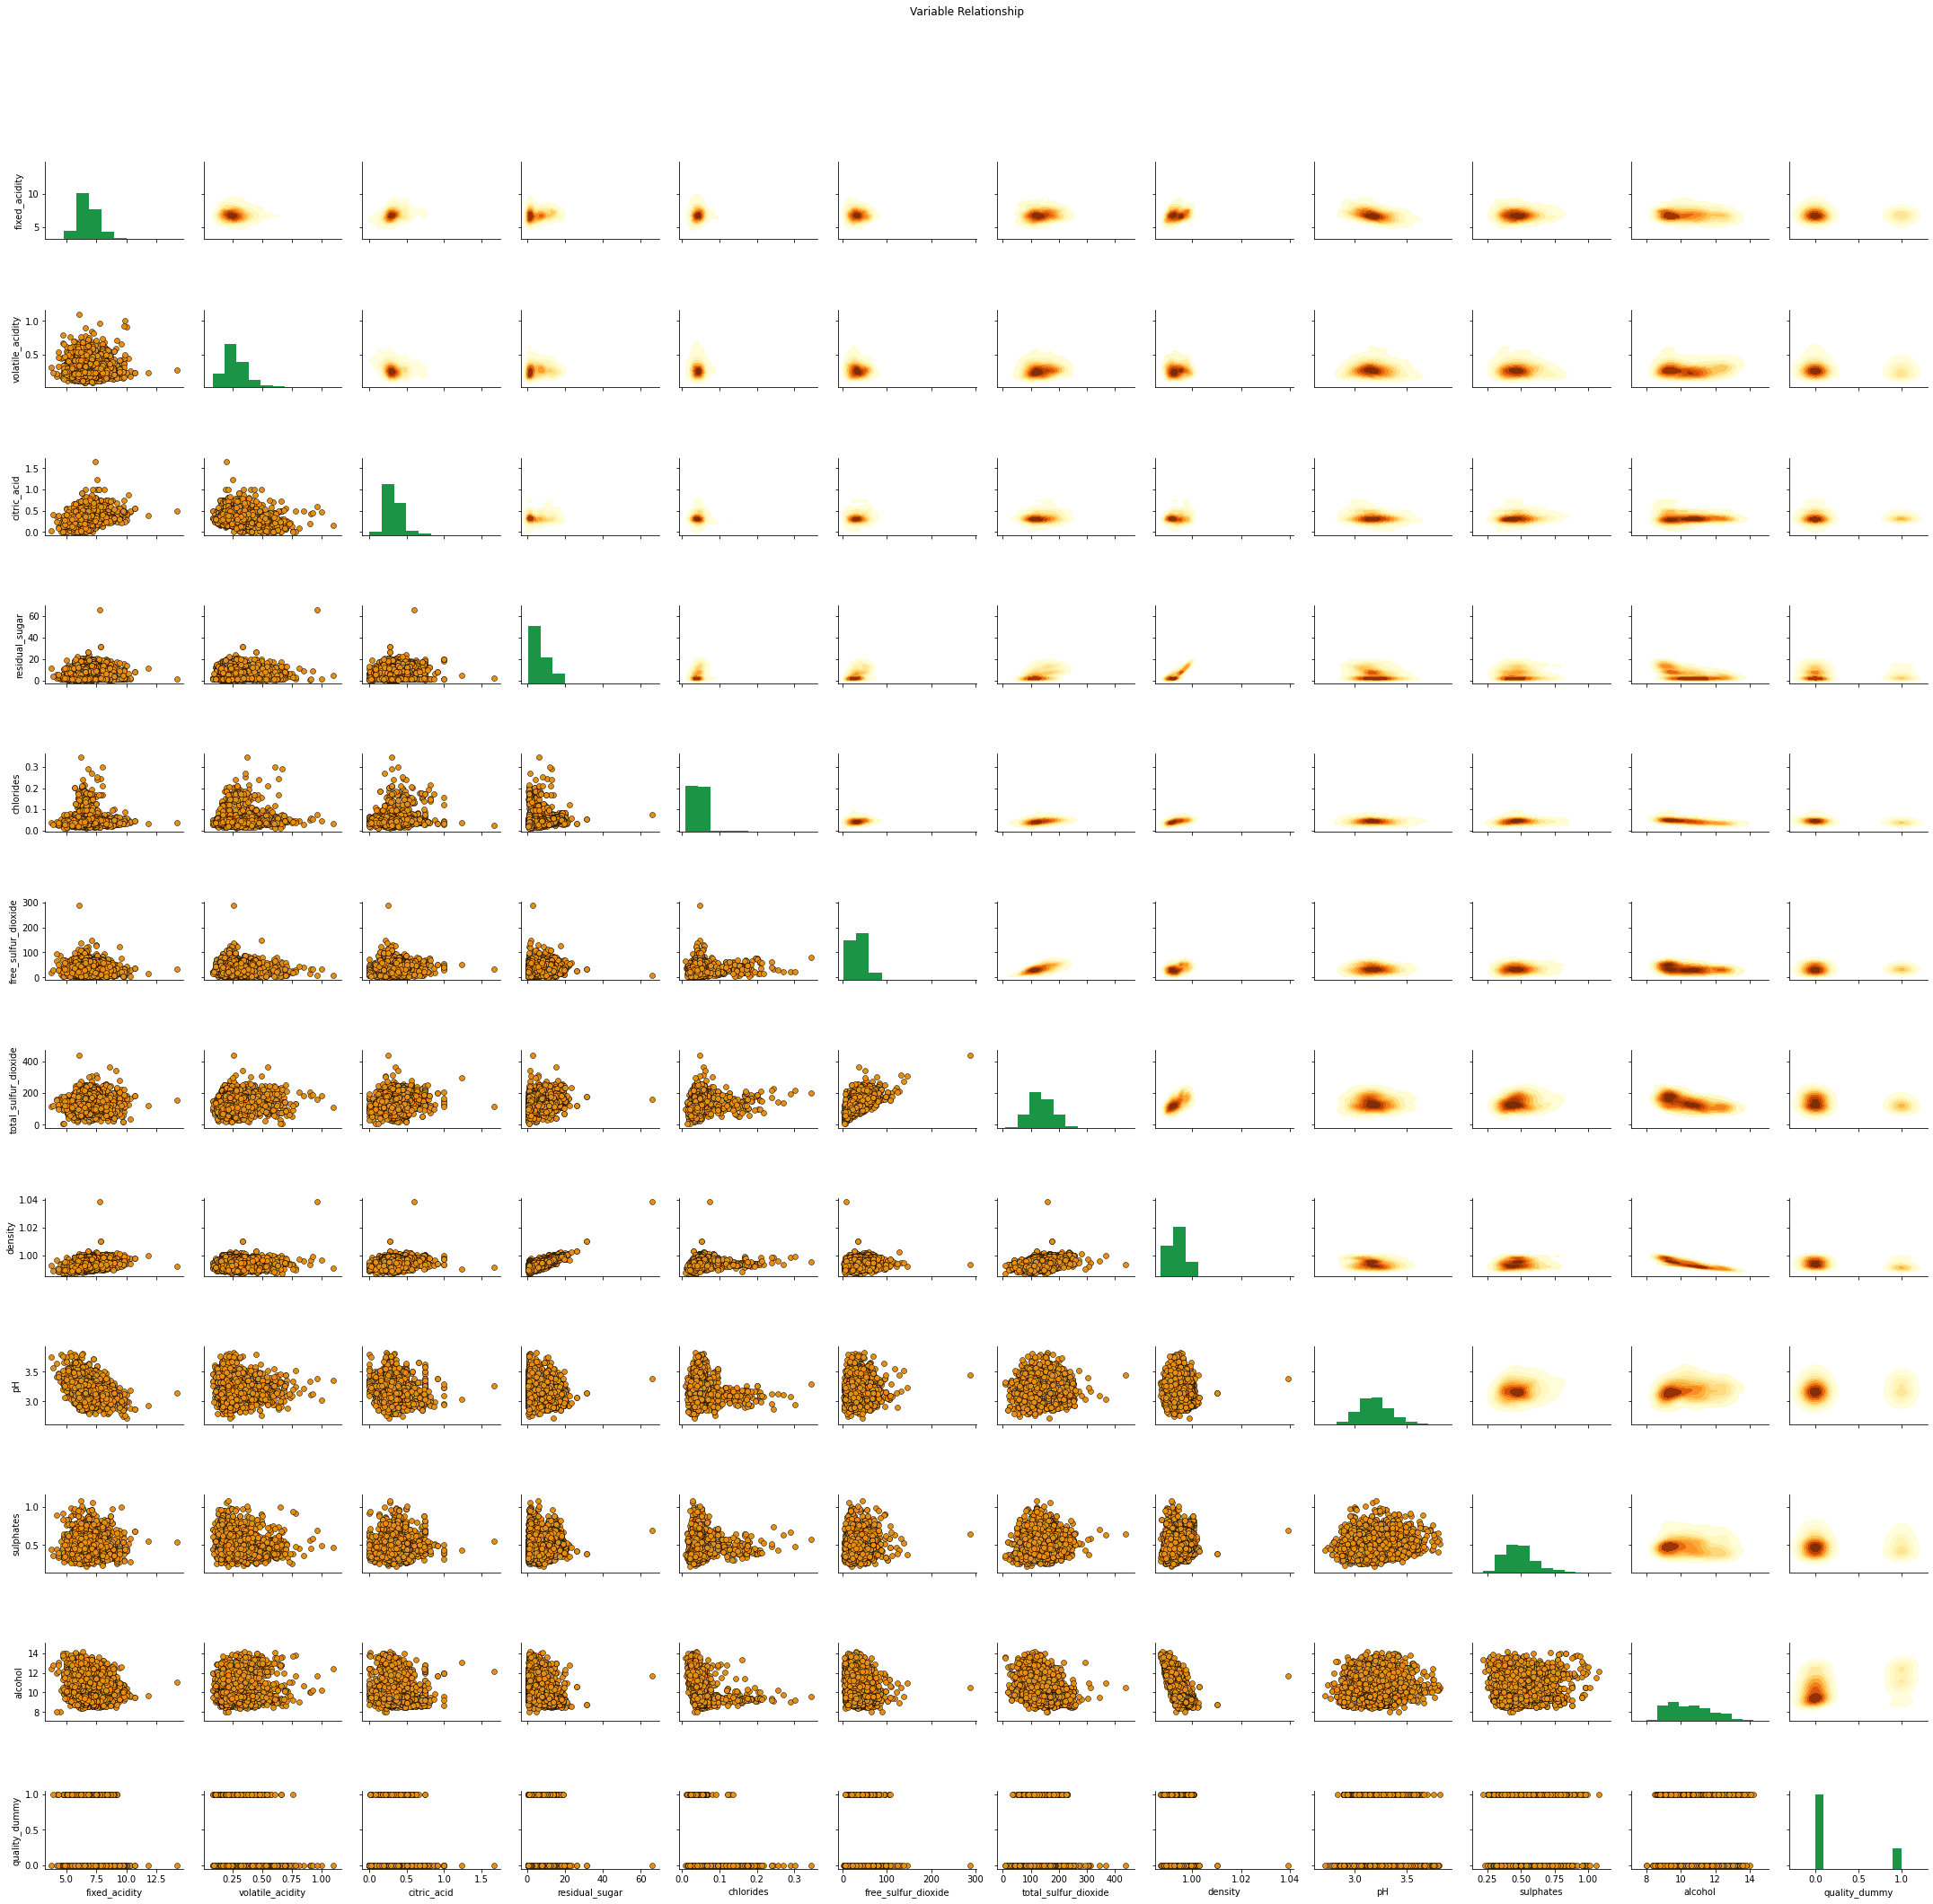

In [0]:
g = sns.PairGrid(dados_pandas)
g = g.map_upper(sns.kdeplot, cmap = 'YlOrBr', shade = True)     #KDE
g = g.map_diag(plt.hist, color = '#1c9446')                                           #Histogram
g = g.map_lower(sns.scatterplot, color='#e68e12', edgecolor = 'k')                    #Scatter

g.fig.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.9)
g.fig.suptitle('Variable Relationship')
plt.show()

### 2.4.3 - Correlação entre as Variáveis

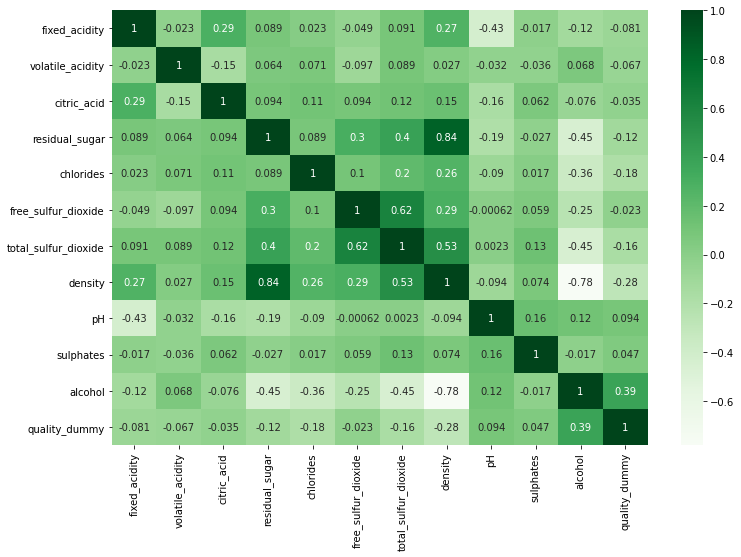

In [0]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(dados_pandas.corr(), cmap='Greens', annot=True)
plt.show()

## 2.5.0 - MLlib

Agora, realizamos a modelagem dos dados. Para isso, iremos dar preferência para a regressão logística e para Random Forest, dado que esses algoritmos, no MLlib, permitem lidar de uma melhor forma com dados desbalanceados (nosso caso, vide primeiro gráfico) que os outros algoritimos disponíveis.

Refrência: [DataTrigger](https://www.datatrigger.org/post/spark_3_weighted_random_forest/)

### 2.5.1 - Pré Processamento Extra

A primeira coisa que precisamos fazer é lidar com o fato de estarmos trabalhando com dados desbalanceados. No PySpark isso é possível para os modelos regressão logística e Random Forest. Para isso ser efetivado, precisamos criar uma coluna com os pesos de cada classe e incorporá-la no dataframe.

In [0]:
import pandas as pd
counts = dados.groupBy('quality_dummy').count().toPandas()

# Counts
count_one = counts[counts['quality_dummy']==1]['count'].values[0]
count_total = counts['count'].sum()

# Weights
c = 2
weight_one = count_total / (c * count_one)
weight_zero = count_total / (c * (count_total - count_one))

# Append weights to the dataset
from pyspark.sql.functions import col

dados = dados.withColumn("weight", when(col("quality_dummy") ==1, weight_one).otherwise(weight_zero))

# Check everything seems ok
dados.select('quality_dummy', 'weight').where(col('quality_dummy')==1).show(3)

+-------------+-----------------+
|quality_dummy|           weight|
+-------------+-----------------+
|            1|2.310377358490566|
|            1|2.310377358490566|
|            1|2.310377358490566|
+-------------+-----------------+
only showing top 3 rows



In [0]:
dados.select('quality_dummy', 'weight').where(col('quality_dummy')==0).show(3)

+-------------+------------------+
|quality_dummy|            weight|
+-------------+------------------+
|            0|0.6380927566440855|
|            0|0.6380927566440855|
|            0|0.6380927566440855|
+-------------+------------------+
only showing top 3 rows



Agora, dividimos nossos dados em treino e teste

In [0]:
train, test = dados.randomSplit([.8, .2], seed = 0)

Agora, formatamos os dados para os modelos da biblioteca MLlib.

In [0]:
# Format the data for MLlib models
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols=dados.schema.names[:-2], outputCol="features")
train = vector_assembler.transform(train)
test = vector_assembler.transform(test)

### 2.5.2 - Fit e Transform dos Modelos

Fitamos e realizamos previsões para o modelo Random Forrest e Regressão Logística.

In [0]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest without weights
rf = RandomForestClassifier(numTrees = 200, featuresCol='features', labelCol='quality_dummy', seed=0)
rf = rf.fit(train)

# Random Forest with weights
rfw = RandomForestClassifier(numTrees = 200, featuresCol='features', labelCol='quality_dummy', weightCol='weight', seed=0)
rfw = rfw.fit(train)

In [0]:
# Logistic Regression without weights
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol='features', labelCol='quality_dummy')
lr = lr.fit(train)

# Logistic Regression with weights
lrw = LogisticRegression(featuresCol='features', labelCol='quality_dummy', weightCol='weight')
lrw = lrw.fit(train)

In [0]:
# Predict the outcome for the test set using the four different models computed above
res_rf = rf.transform(test)
res_rfw = rfw.transform(test)
res_lr = lr.transform(test)
res_lrw = lrw.transform(test)

### 2.5.3 - Avaliamos os resultados

In [0]:
# Random Forest without weights
res_rf.groupBy('quality_dummy', 'prediction').count().show()

+-------------+----------+-----+
|quality_dummy|prediction|count|
+-------------+----------+-----+
|            0|       0.0|  804|
|            1|       0.0|  137|
|            1|       1.0|   59|
|            0|       1.0|   37|
+-------------+----------+-----+



In [0]:
# Random Forest with weights
res_rfw.groupBy('quality_dummy', 'prediction').count().show()

+-------------+----------+-----+
|quality_dummy|prediction|count|
+-------------+----------+-----+
|            0|       0.0|  629|
|            0|       1.0|  212|
|            1|       0.0|   37|
|            1|       1.0|  159|
+-------------+----------+-----+



In [0]:
# Logistic Regression without weights
res_lr.groupBy('quality_dummy', 'prediction').count().show()

+-------------+----------+-----+
|quality_dummy|prediction|count|
+-------------+----------+-----+
|            0|       0.0|  785|
|            1|       0.0|  139|
|            1|       1.0|   57|
|            0|       1.0|   56|
+-------------+----------+-----+



In [0]:
# Logistic Regression with weights
res_lrw.groupBy('quality_dummy', 'prediction').count().show()

+-------------+----------+-----+
|quality_dummy|prediction|count|
+-------------+----------+-----+
|            0|       0.0|  573|
|            0|       1.0|  268|
|            1|       0.0|   41|
|            1|       1.0|  155|
+-------------+----------+-----+



In [0]:
# Compute the area under the PR curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def evaluateModel (predictions, metricName):
    pr = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol="quality_dummy", metricName=metricName)
    pr = pr.evaluate(predictions)
    
    return pr

previsao_modelos = [res_rf, res_rfw, res_lr, res_lrw]
nomes_modelos = ['Random Forest', 'Random Forest Weights', 'Logistic Regression', 'Logistic Regression Weights']
metricas_aval = ['areaUnderROC', 'areaUnderPR']
nomes_metricas = ['Área Abaixo da Curva ROC', 'Área Abaixo da Curva Precision/Recall']

for i in range(len(metricas_aval)):
    print('\n')
    for j in range(len(previsao_modelos)):
        pr = evaluateModel(previsao_modelos[j], metricas_aval[i])
        print(f"A {nomes_metricas[i]} no modelo {nomes_modelos[j]} é de {pr*100}%")



A Área Abaixo da Curva ROC no modelo Random Forest é de 62.85125822029168%
A Área Abaixo da Curva ROC no modelo Random Forest Weights é de 77.9571816836128%
A Área Abaixo da Curva ROC no modelo Logistic Regression é de 61.21144652867092%
A Área Abaixo da Curva ROC no modelo Logistic Regression Weights é de 73.6074037224878%


A Área Abaixo da Curva Precision/Recall no modelo Random Forest é de 46.58486601607857%
A Área Abaixo da Curva Precision/Recall no modelo Random Forest Weights é de 40.59594563820844%
A Área Abaixo da Curva Precision/Recall no modelo Logistic Regression é de 39.25801206889255%
A Área Abaixo da Curva Precision/Recall no modelo Logistic Regression Weights é de 34.78732092767347%


Como podemos perceber, houve uma melhoria considerável do modelo quando lidamos explicitamente com o desbalanceamento e o modelo Random Forest foi superior para essa modelagem.